<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf
#tf.compat.v1.enable_eager_execution()

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.3.1'

In [4]:
from astropy.cosmology import Planck18_arXiv_v2 as cosmo

In [5]:
import tensorflow_datasets as tfds

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [7]:
! pip install tensorflow-probability==0.11.0
    

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [8]:
import tensorflow_probability as tfp

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking
import tensorflow.keras.backend as K

In [10]:
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [11]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

#### load some SDSS data


In [12]:
import sdss_pae.sdss_dataset as sdss 

In [13]:
ds, info = tfds.load('SDSS', data_dir='/global/cscratch1/sd/vboehm/Datasets/',with_info=True, split='train')

In [14]:
(100000*5000*3*8)/1e9

12.0

In [15]:
# use only galxies for now
select_by = 2
# de-redhsift or not?
de_redshift = False

In [16]:


z_ref=0.1
ld_ref = cosmo.luminosity_distance(z_ref)

zs = np.linspace(0,4,800, dtype=np.float32)
yref = cosmo.luminosity_distance(zs).astype(np.float32)

In [17]:


spline = tfp.math.interp_regular_1d_grid(x=np.logspace(-4,0.5,dtype=np.float32), x_ref_min=0, x_ref_max=4, y_ref=yref)


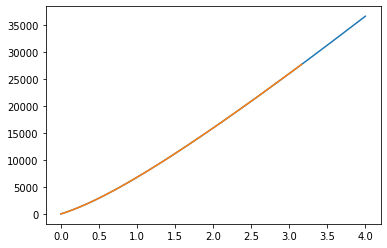

In [18]:
plt.plot(zs, yref)
plt.plot(np.logspace(-4,0.5), spline)

In [19]:

def filter_fn(x):
    if select_by is not None:
        return tf.math.equal(x['label'], select_by)
    else: return 1

ds = ds.filter(filter_fn)

In [20]:
DATASET_SIZE=len(list(ds))

In [21]:
print(DATASET_SIZE)

58303


0.053504556 2 0.053504556


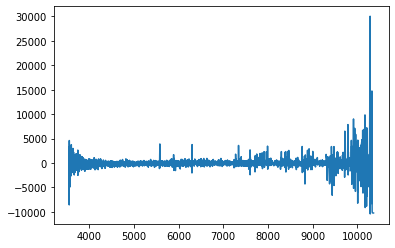

0.80304116 2 0.80304116


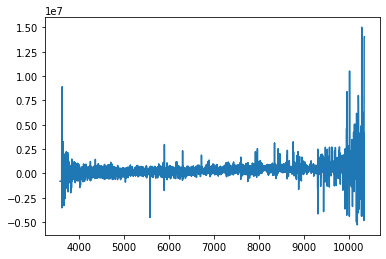

0.57095224 2 0.57095224


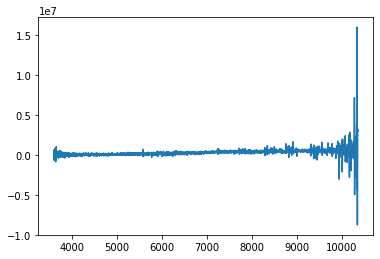

0.21866587 2 0.21866587


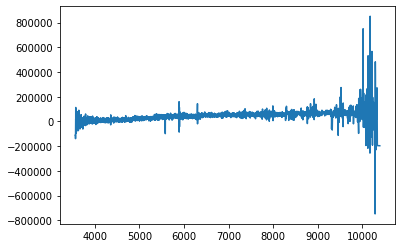

0.5995037 2 0.5995037


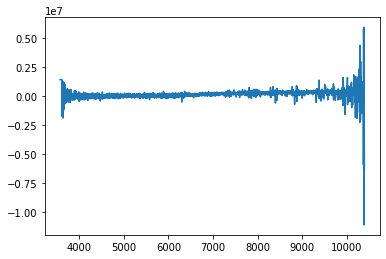

0.5444869 2 0.5444869


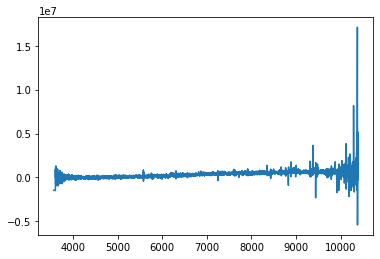

0.43089798 2 0.43089798


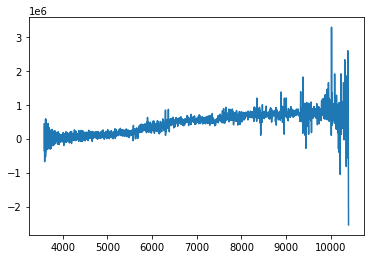

0.6460054 2 0.6460054


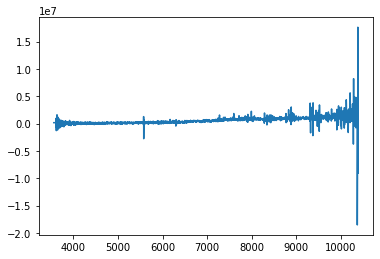

0.17037474 2 0.17037474


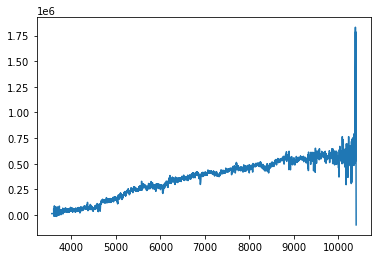

0.5148697 2 0.5148697


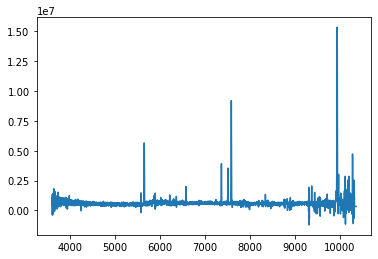

In [22]:
# all pixels are the same size, just padding thegrid, such that they are all on grids of the same length

ii = 0
min_wl= 10000
max_wl= 0
num_npixs = []
img_coeffs1 = []
img_coeffs2 = []
factors = []

for image in tfds.as_numpy(ds):
    log10wl = image['coeffs'][0][0] + image['coeffs'][1][0] * np.arange(image['coeffs'][2][0])
    if de_redshift:
        log10wl = log10wl-np.log10(1+image['redshift'])
    if max(log10wl)>max_wl:
        max_wl= max(log10wl)
    if min(log10wl)<min_wl:
        min_wl=min(log10wl)
    if image['coeffs'][2] not in num_npixs:
        num_npixs.append(image['coeffs'][2][0])
        img_coeffs1.append(image['coeffs'][1][0])
    if image['coeffs'][0] not in img_coeffs2:
        img_coeffs2.append(image['coeffs'][0][0])
    if ii<10:
        print(image['redshift'], image['label'],image['redshift'])
        factor = (cosmo.luminosity_distance(image['redshift'])/ld_ref)**2
        plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)
        plt.show()
        ii+=1
wl_range = (min_wl, max_wl) 

In [23]:
plt.plot(10**log10wl,image['flux'][:,0]*10**log10wl*factor)

(3.549499988555908, 4.017000073290546)


In [24]:
print(len(num_npixs))

43


In [25]:
num_npixs = np.sort(np.asarray(num_npixs))

In [26]:
np.unique(img_coeffs1), np.unique(img_coeffs2)

(array([1.e-04], dtype=float32),
 array([3.5495, 3.5502, 3.5504, 3.5505, 3.5506, 3.5507, 3.5508, 3.5509,
        3.5511, 3.5513, 3.5514, 3.5515, 3.5516, 3.5517, 3.5518, 3.5519,
        3.552 , 3.5521, 3.5523, 3.5525, 3.5526, 3.5527, 3.5529, 3.5531,
        3.5532, 3.5534, 3.554 , 3.5542, 3.5543, 3.5544, 3.5545, 3.5546,
        3.5548, 3.5549, 3.555 , 3.5551, 3.5565], dtype=float32))

In [27]:
num_npixs

array([4595., 4607., 4608., 4609., 4610., 4611., 4615., 4616., 4618.,
       4619., 4622., 4625., 4629., 4632., 4634., 4635., 4638., 4639.,
       4641., 4643., 4644., 4645., 4646., 4647., 4648., 4649., 4650.,
       4651., 4652., 4653., 4654., 4655., 4656., 4657., 4660., 4661.,
       4662., 4663., 4664., 4665., 4666., 4668., 4670.], dtype=float32)

In [28]:
# compute number of pixels that span entire wl range:
npix_max = int((wl_range[1]-wl_range[0])/np.unique(img_coeffs1))
print(npix_max)

4675


In [29]:
ind1 = np.floor((np.log10(5560)-wl_range[0])/np.unique(img_coeffs1))

In [30]:
ind2 = np.ceil((np.log10(5590)-wl_range[0])/np.unique(img_coeffs1))

In [31]:
line_index=[[np.int64(ind1[0]+ii),0] for ii in range(np.int(ind2-ind1))]

In [32]:
# computing padding to align all spectra in wavelength
# log10 wl_min = c0-c1*pad_left  - log10(1+z)
# log10 wl_max = c0+c1*npix+c1*pad_right - log10(1+z)

In [33]:
# mask (inverse noise weight or add noise) -> padding (takes care of de-redshifting)

def preprocessing(d, de_redshift, dlum, extra_mask, downsample, factor, detrend, rescale, scale, line_index, avg_mask, extra_padding, pad):
    
    data                   = d['flux']
    noise                  = d['inv_var']
    if dlum:
        log10wl            = tf.expand_dims(d['coeffs'][0][0] + d['coeffs'][1][0] * tf.range(d['coeffs'][2][0]),-1)
        dlum               = tfp.math.interp_regular_1d_grid(x=d['redshift'], x_ref_min=0, x_ref_max=4, y_ref=yref)
        factor             = (dlum/ld_ref)**2
        data               = (data*tf.pow(10.,log10wl))*factor
        noise              = 1./tf.square(tf.sqrt(1./d['inv_var'])*tf.pow(10.,log10wl)*factor)
        
    if de_redshift:
        pad_left       = (wl_range[0]+ tf.math.log(1+d['redshift'])/tf.math.log(10.)-d['coeffs'][0][0])/(-d['coeffs'][1][0])
        pad_right      = (wl_range[1]+ tf.math.log(1+d['redshift'])/tf.math.log(10.)-d['coeffs'][0][0])/(d['coeffs'][1][0])
    else:
        pad_left       = (wl_range[0]-d['coeffs'][0][0])/(-d['coeffs'][1][0])
        pad_right      = (wl_range[1]-(d['coeffs'][1][0]*d['coeffs'][2][0]+d['coeffs'][0][0]))/(d['coeffs'][1][0])
    
    
    ## padding to bring everything to the same length
    pad_left       = tf.maximum(tf.math.round(pad_left),0)    
    pad_right      = tf.maximum(tf.math.round(pad_right),0)
    
    if not tf.math.equal(pad_left+pad_right+d['coeffs'][2][0]-npix_max,0):
        if tf.math.greater(pad_left, pad_right):
            pad_left=pad_left-1
        else:
            pad_right=pad_right-1
    
    pad_left       = tf.cast(pad_left,tf.int32)
    pad_right      = tf.cast(pad_right,tf.int32)
    
    padded         = tf.pad(data, [[pad_left,pad_right],[0,0]])
    padded_mask    = tf.pad(tf.cast(d['and_mask'],tf.float32), [[pad_left,pad_right],[0,0]])
    padded_noise   = tf.pad(noise, [[pad_left,pad_right],[0,0]])
    
    if extra_mask:
        indices        = tf.constant(line_index,dtype=tf.int64)
        sparse         = tf.SparseTensor(indices, np.repeat(0.,25) , tf.cast((npix_max,1),tf.int64))
        sparse         = tf.sparse.to_dense(sparse, default_value=1, validate_indices=True)
        padded_mask    = padded_mask*tf.cast(sparse,tf.float32)
        
    flux               = tf.ensure_shape(padded,(npix_max,1))
    padded_mask        = tf.ensure_shape(padded_mask,(npix_max,1))
    padded_noise       = tf.ensure_shape(padded_noise,(npix_max,1))
    npix               = npix_max
    
    if downsample:
        flux           = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(flux[None,...]))
        npix           = npix_max//factor
        flux           = tf.expand_dims(flux,1)
        if avg_mask:
            padded_mask = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(padded_mask[None,...]))
        else:
            padded_mask = tf.squeeze(MaxPooling1D(factor,factor,'same',data_format="channels_last")(padded_mask[None,...]))
        padded_mask = tf.expand_dims(padded_mask,1)
        
        nn            = tf.where(padded_noise>0,padded_noise,100)
        noise         = tf.squeeze(AveragePooling1D(factor,factor,'same',data_format="channels_last")(1./nn[None,...]))
        inv_noise     = 1./(noise/factor)
        inv_noise     = tf.expand_dims(inv_noise,1)

        padded_noise  = tf.where(inv_noise!=100*factor,inv_noise,0)
        padded_noise  = tf.ensure_shape(inv_noise,(npix,1))
        
    else:
        factor         = 1 
        
    if rescale: 
        flux           = flux/scale
        padded_noise   = padded_noise*scale**2
        
    if detrend:
        scale          = 125//factor
        smooth_flux    = tf.squeeze(AveragePooling1D(scale,scale,'VALID',data_format="channels_last")(flux[None,...]))
        y              = tf.gather(smooth_flux,[3, (npix//2)//scale,npix//scale-3])
        x1             = scale*3
        x2             = npix//2
        x3             = npix-scale*3
        a              = (x1*(y[2]-y[1])+x2*(y[0]-y[2])+x3*(y[1]-y[0]))/((x1-x2)*(x1-x3)*(x2-x3))
        b              = ((y[1]-y[0])-a*(x2**2+x1**2))/(x2-x1)
        c              = y[0]-a*x1**2-b*x1
        flux           = flux -(a*np.arange(npix)**2+b*np.arange(npix)+c)[...,None]
    else:
        a              = 0
        b              = 0
        c              = 0
        smooth_flux    = flux 
    
    if extra_padding:
        flux          = tf.pad(flux, [[0,pad],[0,0]])
        padded_mask   = tf.pad(padded_mask, [[0,pad],[0,0]])
        padded_noise  = tf.pad(padded_noise, [[0,pad],[0,0]])
        
        
    return dict(flux=flux, smooth_flux=smooth_flux, mask=padded_mask,  inverse=padded_noise, detrend=[tf.squeeze(d['redshift']),a,b,c])
    

In [34]:
prep_data = ds.map(lambda x, de_redshift=False, dlum=False, extra_mask=False, downsample=True, factor=5, detrend=True, rescale=True, scale=10, line_index=None, avg_mask = False, extra_padding=True, pad=5: preprocessing(x, de_redshift, dlum, extra_mask, downsample, factor, detrend, rescale, scale, line_index, avg_mask,extra_padding=extra_padding, pad=pad))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


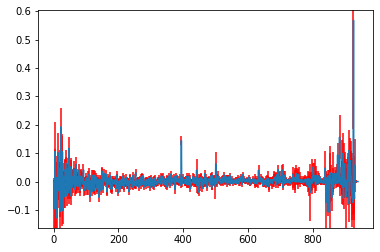

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


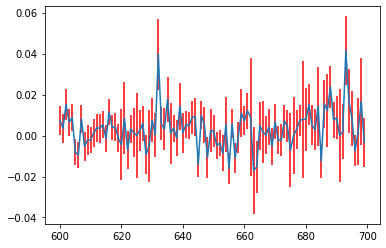

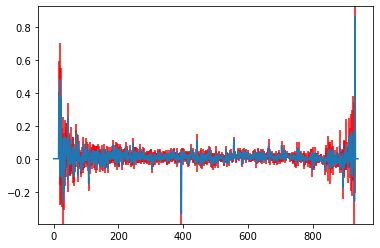

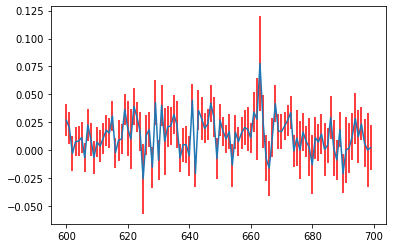

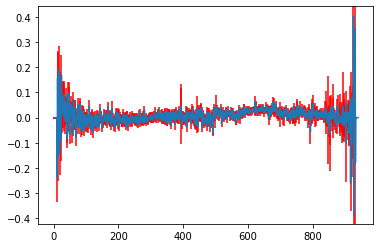

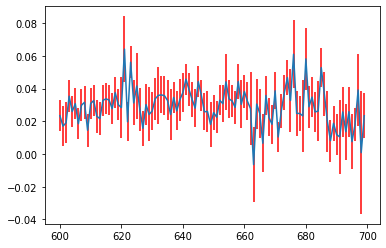

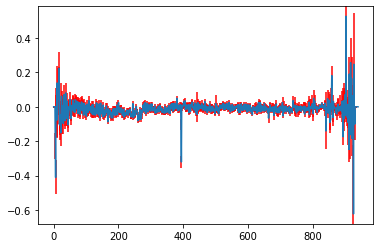

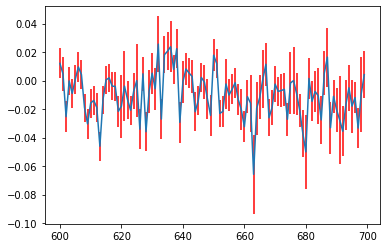

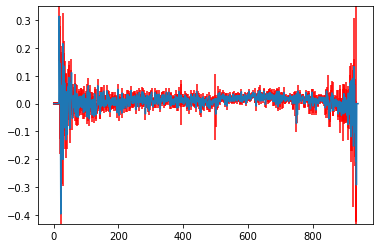

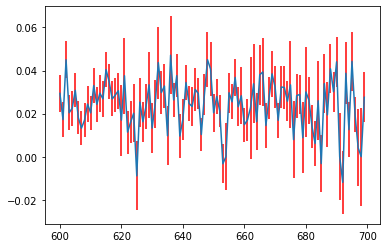

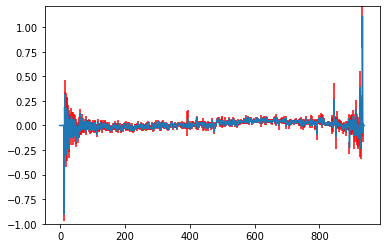

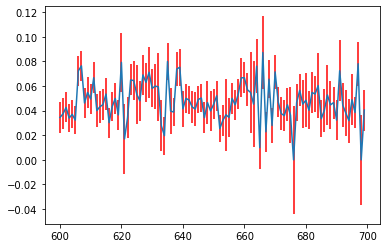

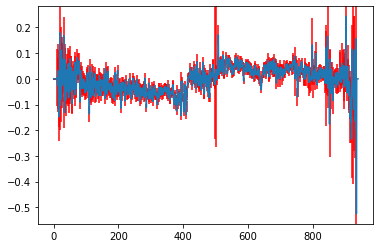

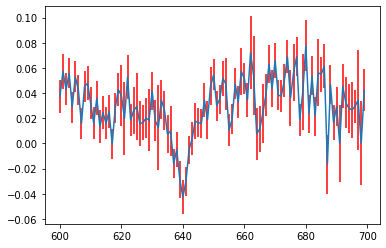

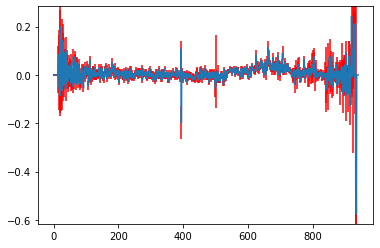

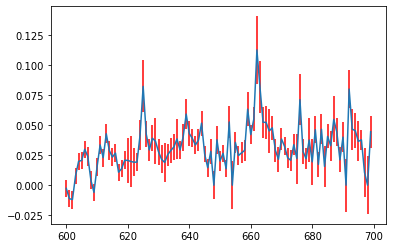

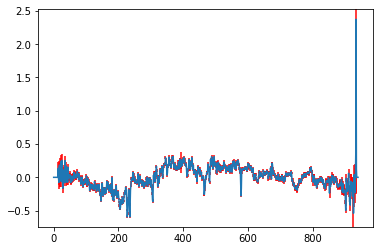

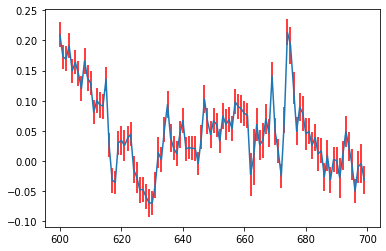

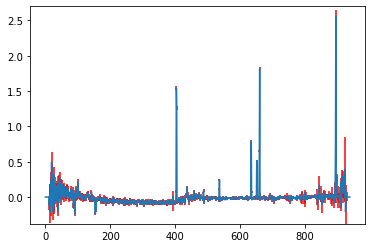

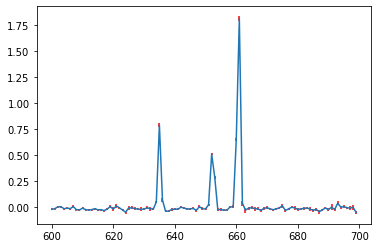

In [44]:
shapes = []
wls = 10**np.linspace(min_wl,max_wl,npix_max)
for ii, image in enumerate(tfds.as_numpy(prep_data)):
    if ii in np.arange(10):
#        plt.axvline(5560)
#        plt.axvline(5590)
#         plt.plot(image['flux'])
#         plt.plot(image['mask']*image['flux'])
        plt.errorbar(np.arange(len(image['flux'])),image['flux']*image['mask'],yerr=np.sqrt(1./np.squeeze(image['inverse'])),ecolor='red')
        plt.show()
        
        plt.errorbar(np.arange(len(image['flux']))[600:700],(image['flux']*image['mask'])[600:700],yerr=np.sqrt(1./np.squeeze(image['inverse']))[600:700],ecolor='red')
        plt.show()
#         print(np.sqrt(1/np.squeeze(image['inverse']))[0:50])
#         print(image['flux'][0:10])
#        plt.ylim(-10,10)
    plt.show()
    if ii==10:
        break

In [37]:
# shapes = []
# wls = 10**np.linspace(min_wl,max_wl,npix_max)
# for ii, image in enumerate(tfds.as_numpy(prep_data)):
#     if ii in np.arange(10):
#         plt.axvline(5560)
#         plt.axvline(5590)
#         plt.plot(wls,image['flux'])
#         plt.plot(wls,image['flux']*image['mask'])
#         plt.plot(wls[::125][1:],np.squeeze(image['smooth_flux']))
#         a,b,c, d = image['detrend']
#         print(d.shape)
#         plt.plot(wls,a*np.arange(npix_max)**2+b*np.arange(npix_max)+c)
#         plt.show()
#         plt.plot(wls,np.squeeze(image['flux'])+(a*np.arange(npix_max)**2+b*np.arange(npix_max)+c))
#         plt.show()
#         plt.plot(wls,np.squeeze(np.sqrt(1/image['inverse'])))
#         plt.show()
#     if image['flux'].shape not in shapes:
#         shapes.append(image['flux'].shape)
#     if ii>10:
#         break
#     plt.show()

In [45]:
latent_dim = 64
dim        = 940

In [46]:
network_type='CNN'

In [47]:
from tensorflow.keras.layers import concatenate as concat

In [48]:
940/5

188.0

In [49]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim,1))
input_params = Input(shape=(4))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))

if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
    x = Reshape((dim,))(input)
    x = tf.concat([x,input_params],axis=1)
    x = LeakyReLU()(Dense(128)(x))
    x = LeakyReLU()(Dense(64)(x))
    x = Dense(latent_dim)(x)  
    x = tf.concat([x,input_params],axis=1)
    #decoder_input = x#tf.concat([x,tf.tile(input_z,[tf.shape(x)[0],1])], axis=1)
    x = LeakyReLU()(Dense(64)(x))
    x = LeakyReLU()(Dense(128)(x))
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(32, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(32, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    y = Flatten()(x)
    x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    z = LeakyReLU()(x)
    x = tf.concat([z,input_params], axis=1)
    x = Dense(30*32,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((30,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = tf.keras.layers.ZeroPadding1D(padding=[0,1])(x)
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    #x, _ = Lambda( lambda x: tf.split(x,num_or_size_splits=(dim,1),axis=1))(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics):
        super().compile(optimizer,metrics)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data= data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][2],input_data[0][3])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}



def custom_metric(y_true, y_pred):
    print(y_true, y_pred)
    loss = tf.math.square(y_true[0]-y_pred)*y_true[3]
    valid_loss = tf.reduce_mean(loss*tf.boolean_mask(loss,y_true[2]))
    return valid_loss
    
    
    
lstm_ae = CustomModel(inputs=[input, input_params, input_mask,input_noise], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=['mse'])

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 940, 1)]     0                                            
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 470, 64)      384         input_1[0][0]                    
__________________________________________________________________________________________________
bn1 (BatchNormalization)        (None, 470, 64)      256         conv1[0][0]                      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 470, 64)      0           bn1[0][0]                        
_______________________________________________________________________________________

In [50]:
# from tensorflow.keras.layers.experimental import preprocessing

# layer_normalize = preprocessing.Normalization()
# layer_normalize.adapt(prep_data.map(lambda x: x['flux']))

In [51]:
# for i, l in enumerate(lstm_ae.layers):
#     print(f'layer {i}: {l}')
#     print(f'has input mask: {l.input_mask}')
#     print(f'has output mask: {l.output_mask}')

In [52]:
BATCH_SIZE   = 128

train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)

train_dataset = prep_data.take(train_size).repeat().map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),x['flux'])).batch(BATCH_SIZE)
test_dataset  = prep_data.skip(train_size).take(test_size).map(lambda x: ((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)
valid_dataset = prep_data.skip(train_size+test_size).take(valid_size).map(lambda x:((x['flux'],x['detrend'], x['mask'], x['inverse']),(x['flux'], x['mask'], x['inverse']))).batch(BATCH_SIZE)


In [53]:
def scheduler(epoch, lr):
...   if epoch < 10:
...     return lr
...   else:
...     return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [54]:
history = lstm_ae.fit(train_dataset,validation_data=valid_dataset, epochs=20, steps_per_epoch=train_size//BATCH_SIZE, callbacks=[callback])

Epoch 1/20
273/273 [==============================] - 60s 218ms/step - training_loss: 54.7968 - val_loss: 0.0104
Epoch 2/20
273/273 [==============================] - 65s 239ms/step - training_loss: 7.0482 - val_loss: 0.0101
Epoch 3/20
273/273 [==============================] - 62s 227ms/step - training_loss: 6.1055 - val_loss: 0.0107
Epoch 4/20
273/273 [==============================] - 64s 235ms/step - training_loss: 5.7021 - val_loss: 0.0112
Epoch 5/20
273/273 [==============================] - 64s 234ms/step - training_loss: 5.4079 - val_loss: 0.0111
Epoch 6/20
273/273 [==============================] - 63s 229ms/step - training_loss: 5.0995 - val_loss: 0.0111
Epoch 7/20
273/273 [==============================] - 65s 236ms/step - training_loss: 3.9402 - val_loss: 0.0102
Epoch 8/20
273/273 [==============================] - 64s 234ms/step - training_loss: 3.6635 - val_loss: 0.0116
Epoch 9/20
273/273 [==============================] - 63s 231ms/step - training_loss: 3.5651 - val_loss

In [55]:
history.history['training_loss']

[4.5337605476379395,
 5.223392963409424,
 5.197097301483154,
 4.953439235687256,
 4.90205192565918,
 3.397925853729248,
 2.7820963859558105,
 3.0015861988067627,
 3.0838875770568848,
 2.605149030685425,
 2.7769625186920166,
 2.623857021331787,
 4.150504112243652,
 2.557335138320923,
 2.2188968658447266,
 2.6891162395477295,
 2.3723692893981934,
 2.222702741622925,
 1.8352713584899902,
 1.8343186378479004]

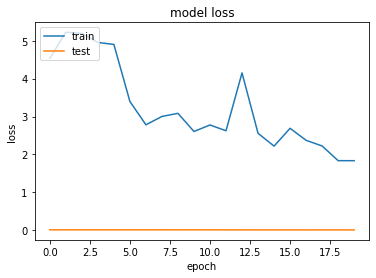

In [56]:
plt.plot(history.history['training_loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [101]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix + 1):
        curr_layer = main_model.get_layer(index=ix)
        new_model.add(curr_layer)
    return new_model

In [57]:
recon_train   = lstm_ae.predict(train_dataset.take(1))
recon_test    = lstm_ae.predict(test_dataset.take(1))

In [58]:
# encoder = extract_layers(lstm_ae, 1, 16)
# encoded = encoder.predict(valid_dataset.take(1))


In [ ]:
encoded.shape

In [ ]:
decoder = extract_layers(lstm_ae, 18, -1)
print(encoded.shape)

In [ ]:
decoder.predict(encoded).shape

(940, 1)


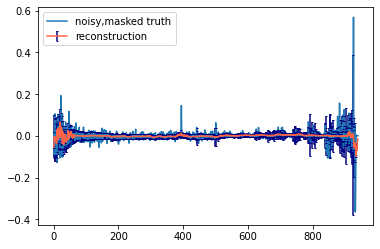

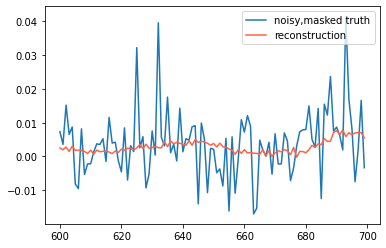

(940, 1)


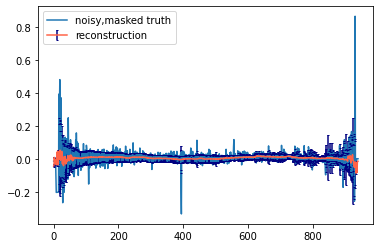

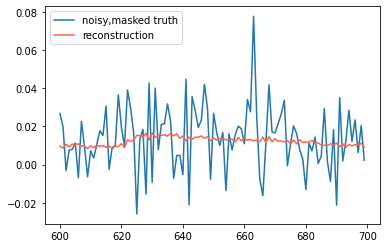

(940, 1)


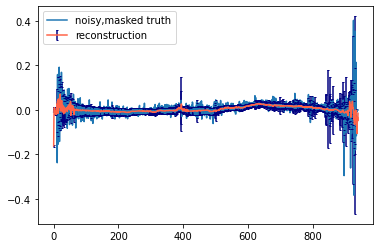

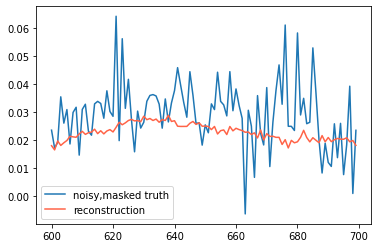

(940, 1)


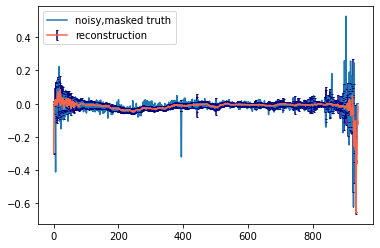

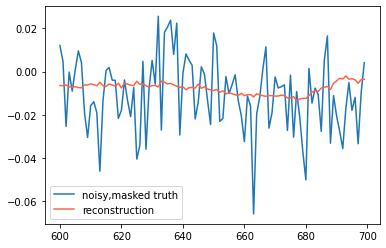

(940, 1)


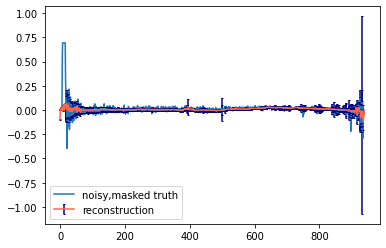

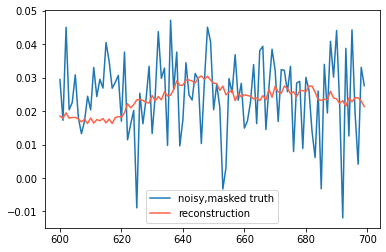

(940, 1)


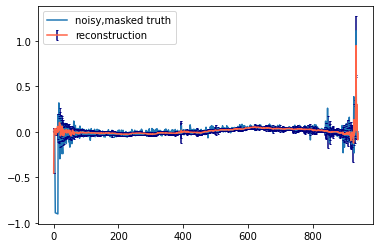

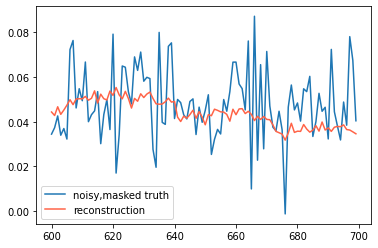

(940, 1)


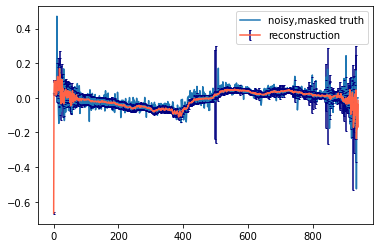

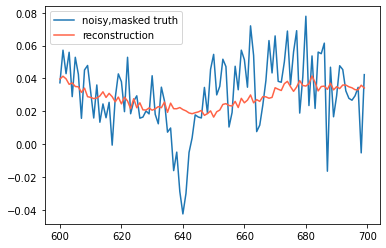

(940, 1)


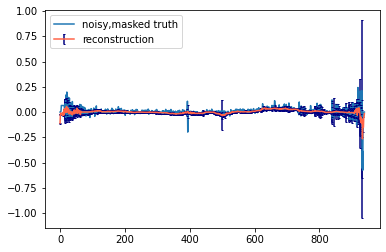

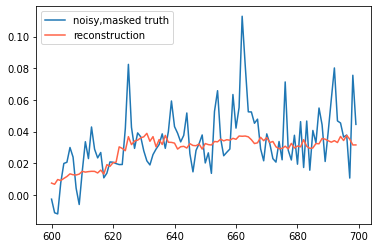

(940, 1)


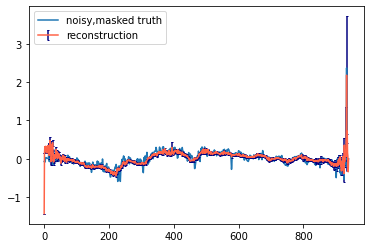

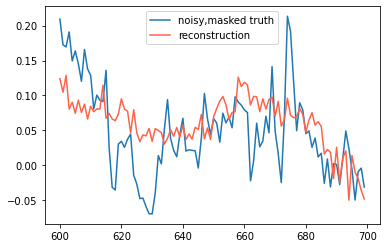

(940, 1)


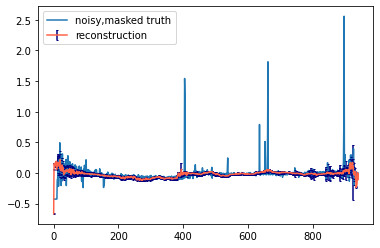

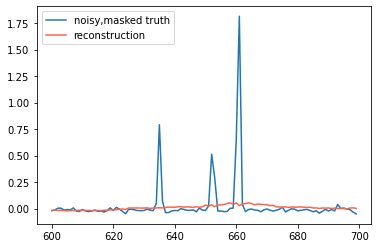

(940, 1)


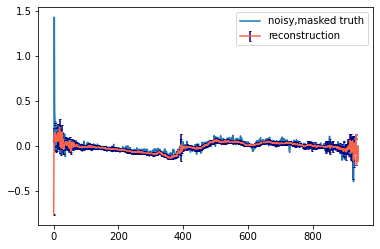

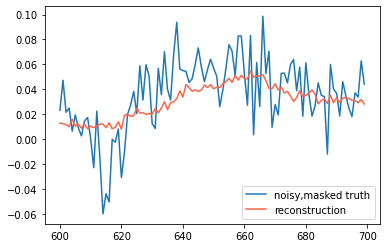

(940, 1)


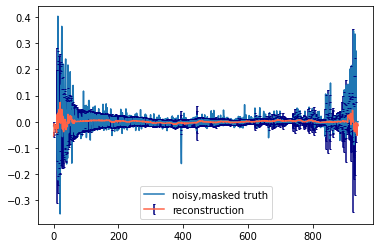

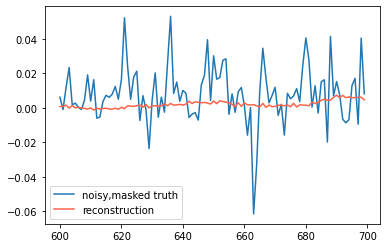

(940, 1)


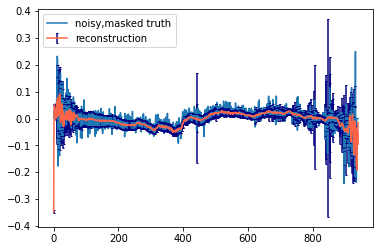

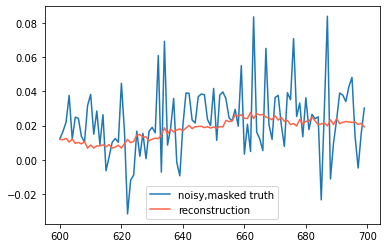

(940, 1)


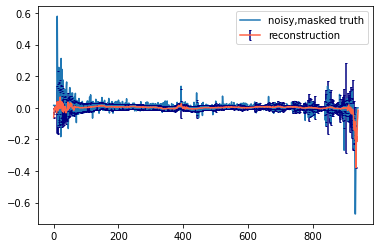

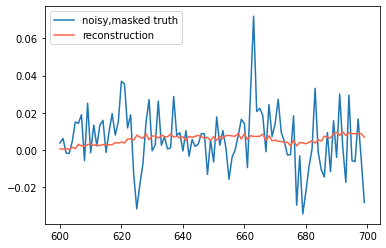

(940, 1)


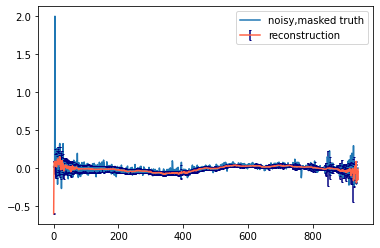

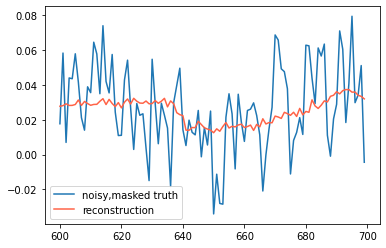

(940, 1)


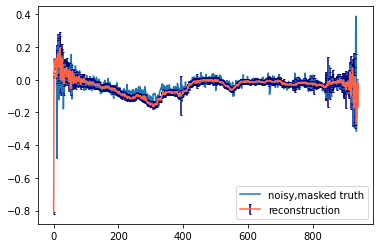

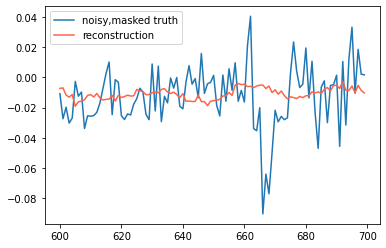

(940, 1)


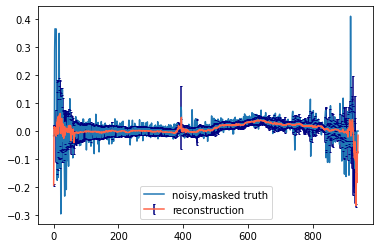

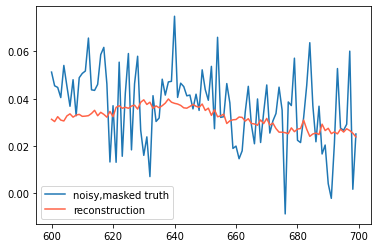

(940, 1)


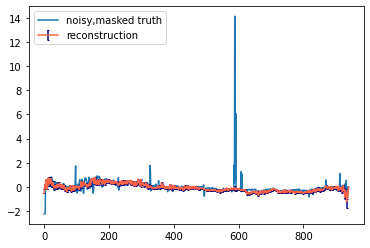

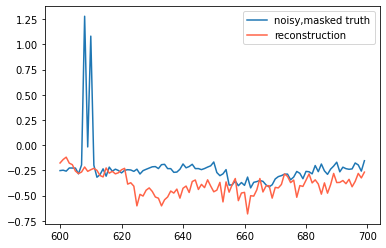

(940, 1)


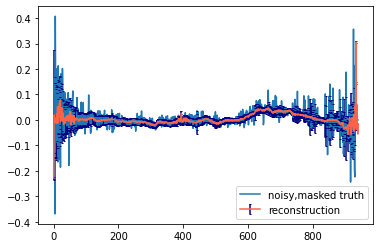

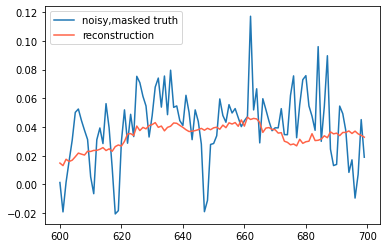

(940, 1)


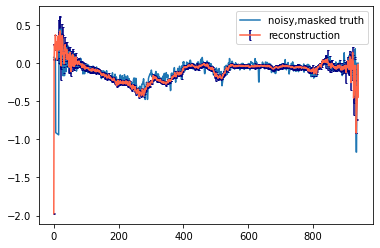

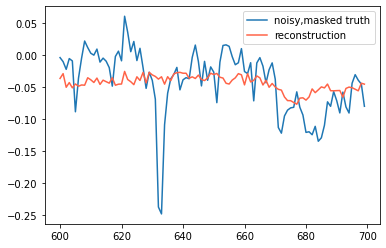

In [66]:
for train in train_dataset.take(1):
    for ii in range(20):
        plt.plot(train[0][0][ii],label='noisy,masked truth')
        #errs = np.zeros(npix_max, np.int32)
        print(train[0][3][ii].shape)
        #errs[np.where(train[0][2][ii].numpy()!=0)[0]] = np.sqrt(1./(train[0][2][ii].numpy()[np.where(train[0][2][ii].numpy()!=0)]))
        plt.errorbar(np.arange(dim),recon_train[ii],yerr=np.squeeze(np.sqrt(1/train[0][3][ii])),label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        #plt.ylim(-3,3)
        plt.legend()
        plt.show()
        plt.plot(np.arange(dim)[600:700],train[0][0][ii][600:700],label='noisy,masked truth')
        plt.errorbar(np.arange(dim)[600:700],recon_train[ii][600:700],label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()

(940, 1) (940,)


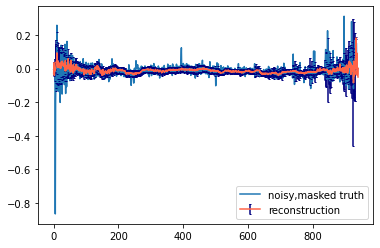

(940, 1) (940,)


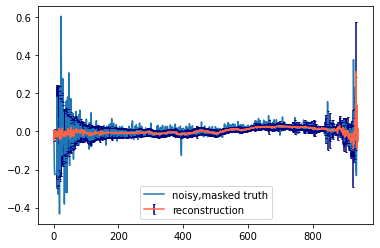

(940, 1) (940,)


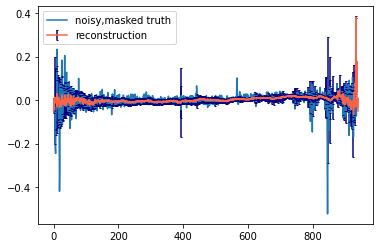

(940, 1) (940,)


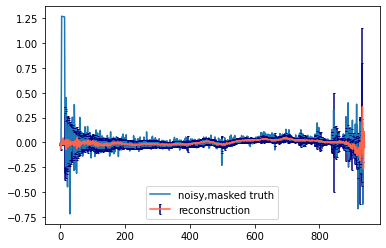

(940, 1) (940,)


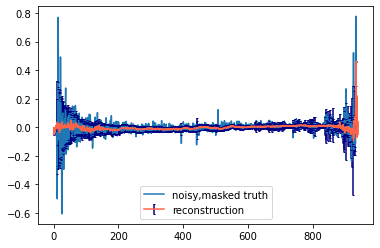

(940, 1) (940,)


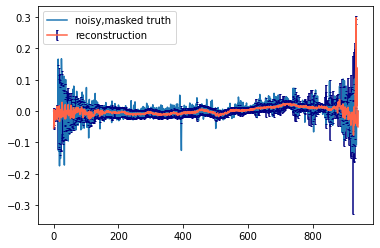

(940, 1) (940,)


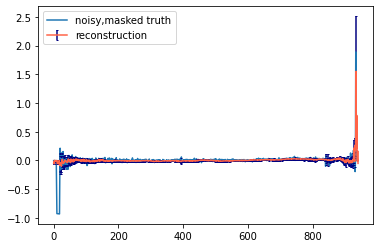

(940, 1) (940,)


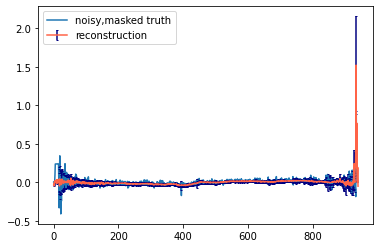

(940, 1) (940,)


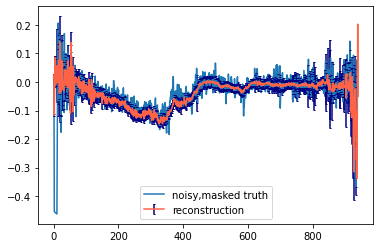

(940, 1) (940,)


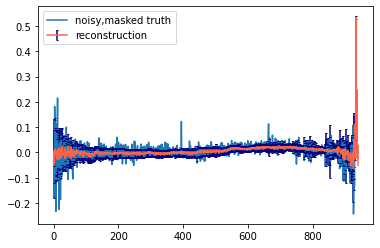

(940, 1) (940,)


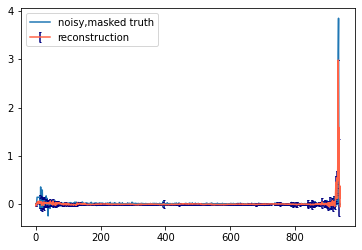

(940, 1) (940,)


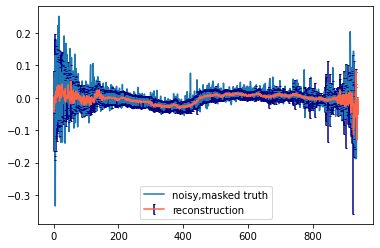

(940, 1) (940,)


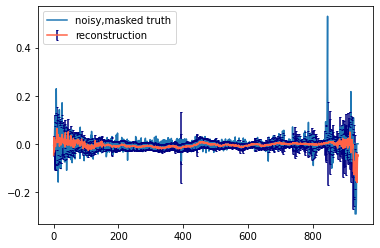

(940, 1) (940,)


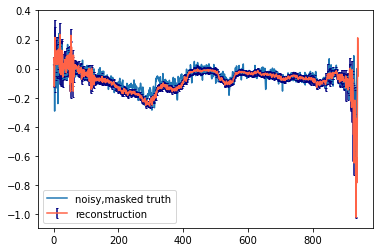

(940, 1) (940,)


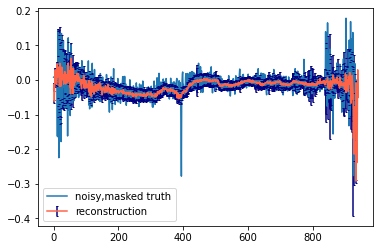

(940, 1) (940,)


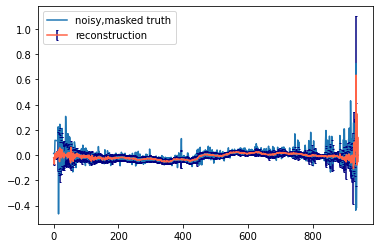

(940, 1) (940,)


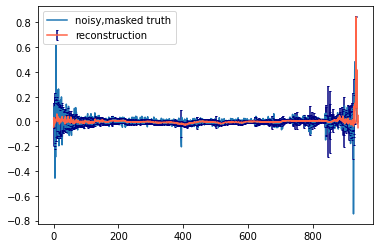

(940, 1) (940,)


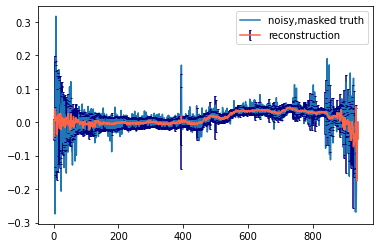

(940, 1) (940,)


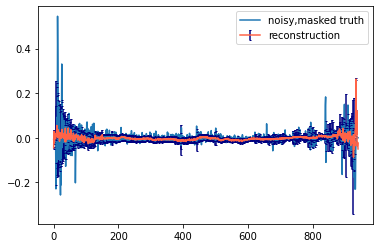

(940, 1) (940,)


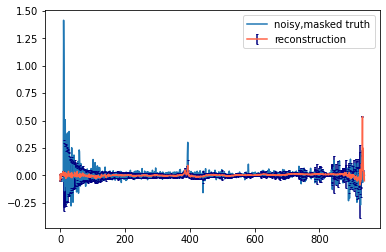

In [86]:
for test in test_dataset.take(1):
    for ii in range(20):
        plt.plot(test[0][0][ii],label='noisy,masked truth')
        errs = np.squeeze(np.sqrt(1/test[0][3][ii]))
        print(recon_test[ii].shape, errs.shape)
        plt.errorbar(np.arange(dim),np.squeeze(recon_test[ii]),yerr=errs,label='reconstruction',elinewidth=0,capsize=1,ecolor='navy',color='tomato')
        plt.legend()
        plt.show()